In [36]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

%load_ext autoreload
%autoreload 2
%matplotlib inline

warnings.filterwarnings('ignore')

# Load data
ust_futures = pd.read_csv('raw_futures_prices.csv', index_col=0, parse_dates=[0]).dropna(how='any', axis=0)

# Potential pairs.
pairs = list(combinations(ust_futures.columns, 2))

# Define spreads

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from collections import defaultdict
from more_itertools import windowed

import v2.copulas.fitting as fitting
import v2.backtest.hedging as hedging
import v2.backtest.signal_ as signal_

# PnL analysis for each pair.
yearly_copulas = {}

# Make a list of years.
years = ['2018', '2019', '2020', '2021', '2022']
years_windowed = list(windowed(years, 3))

for train_start, train_end, test_end in years_windowed:
    # Fit the copulas -- index by trading year for the
    # dictionary.
    yearly_signal_obj = signal_.SignalGeneration(ust_futures, pairs, train_start, train_end, test_end, test_end,copula_type='mixed')
    yearly_copulas[test_end] = yearly_signal_obj

In [38]:
import backtest.backtester as backtest

prep_backtest = {}

for year, signal_obj in yearly_copulas.items():
    prices = signal_obj.prices
    sigs = signal_obj.calc_signals()
    prices = prices.loc[year]
    for col in sigs.columns:
        prices[col] = signal_obj.generate_signals(sigs[col]).values

    prep_backtest[year]= prices.copy()

In [39]:
# Run backtest
dv01s = {
    'TU': 20,
    'FV': 30,
    'TY': 67.4,
    'UXY': 95.5,
    'US': 153.8,
    'WN': 233.6
}


yearly_agg_results = {}
yearly_agg_returns = {}

for year in ['2020', '2021', '2022']:
    agg_results = pd.DataFrame()

    for pair in pairs:
        train_data = yearly_copulas[year].prices[[pair[0], pair[1]]]
        pair_data = prep_backtest[year][[pair[0], pair[1], pair]]
        pair_data = pair_data.rename({pair: 'Signal'}, axis=1)
        pair_data['Betas'] = 1 #dv01s[pair[0]]/dv01s[pair[1]]
        res = backtest.backtest(pair_data)
        agg_results[pair] = res['Total PnL']

    agg_returns = (10_000 + agg_results).pct_change().dropna()
    agg_results = (1 + (agg_results + 10_000).pct_change().dropna()).cumprod() - 1
    yearly_agg_results[year] = agg_results
    yearly_agg_returns[year] = agg_returns

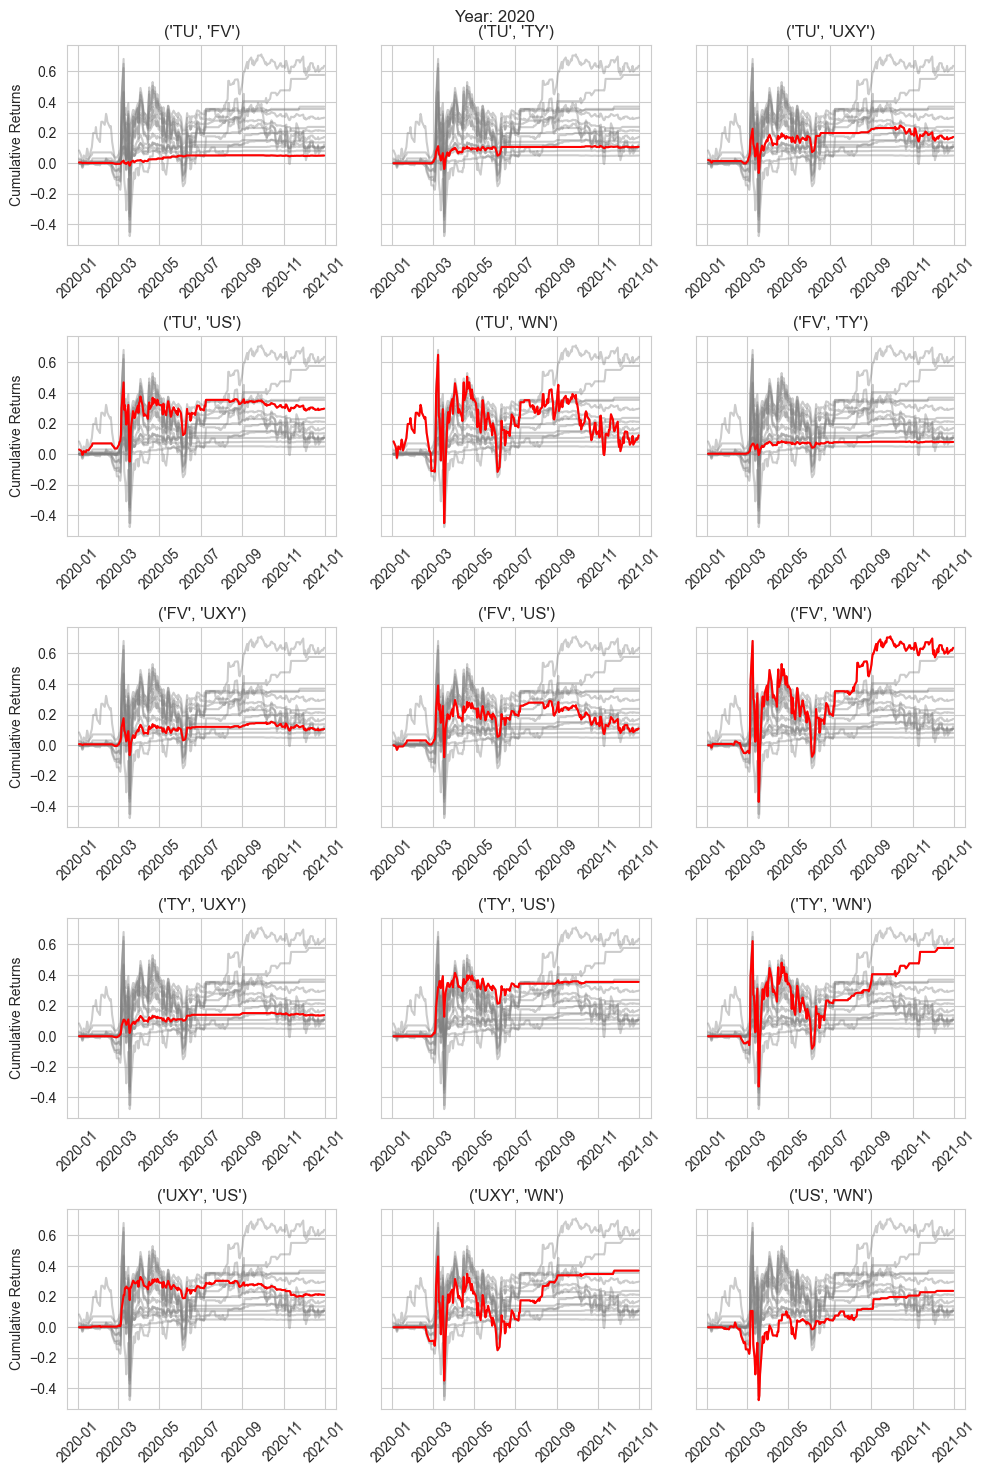

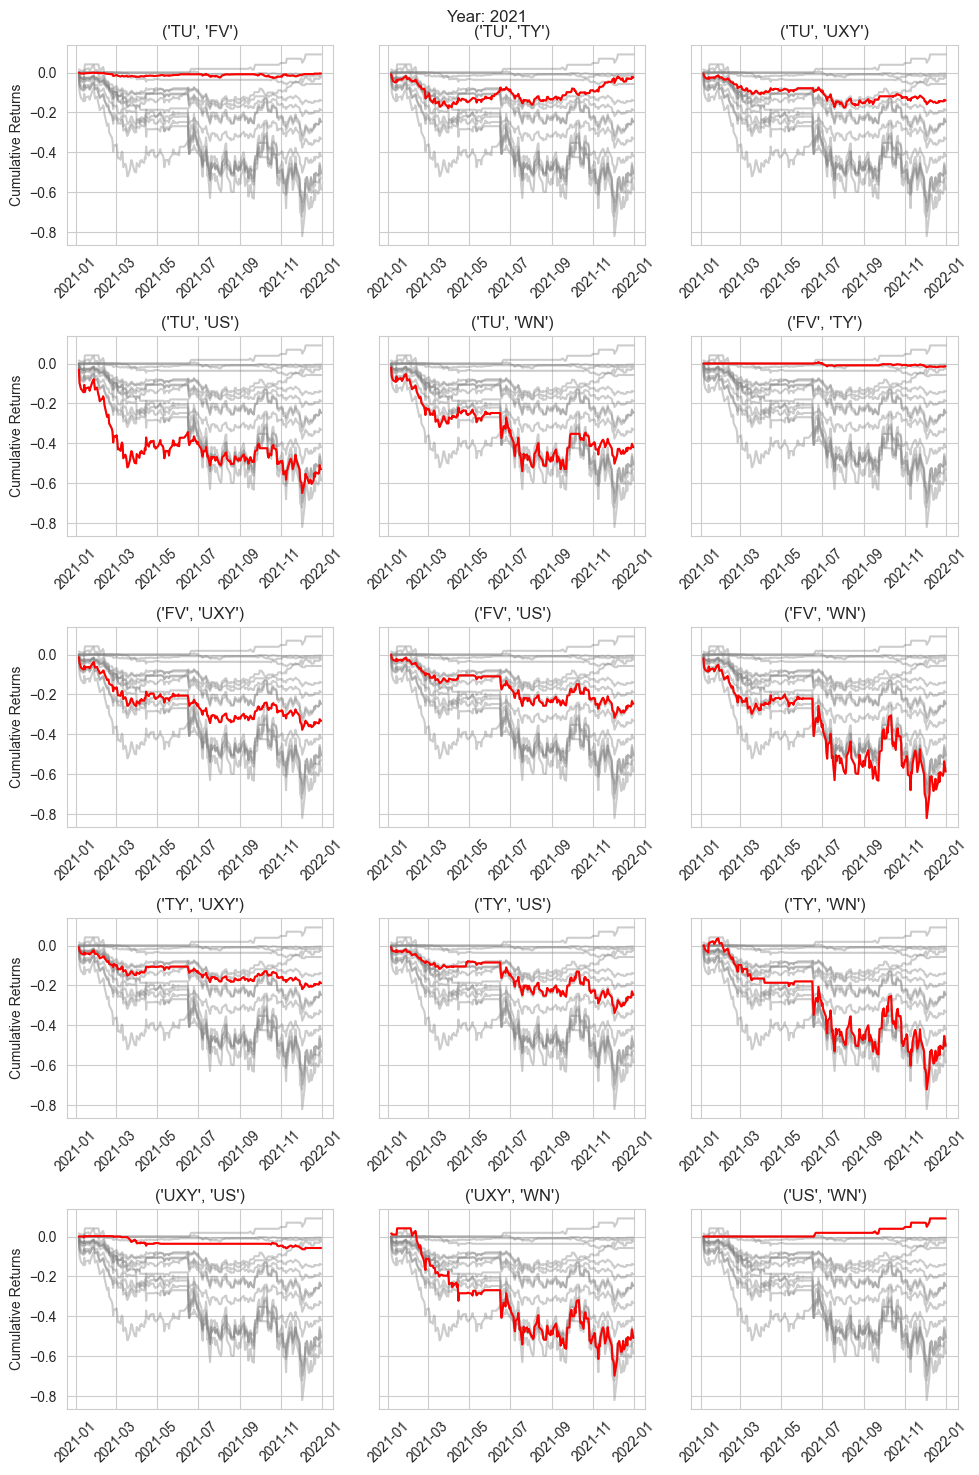

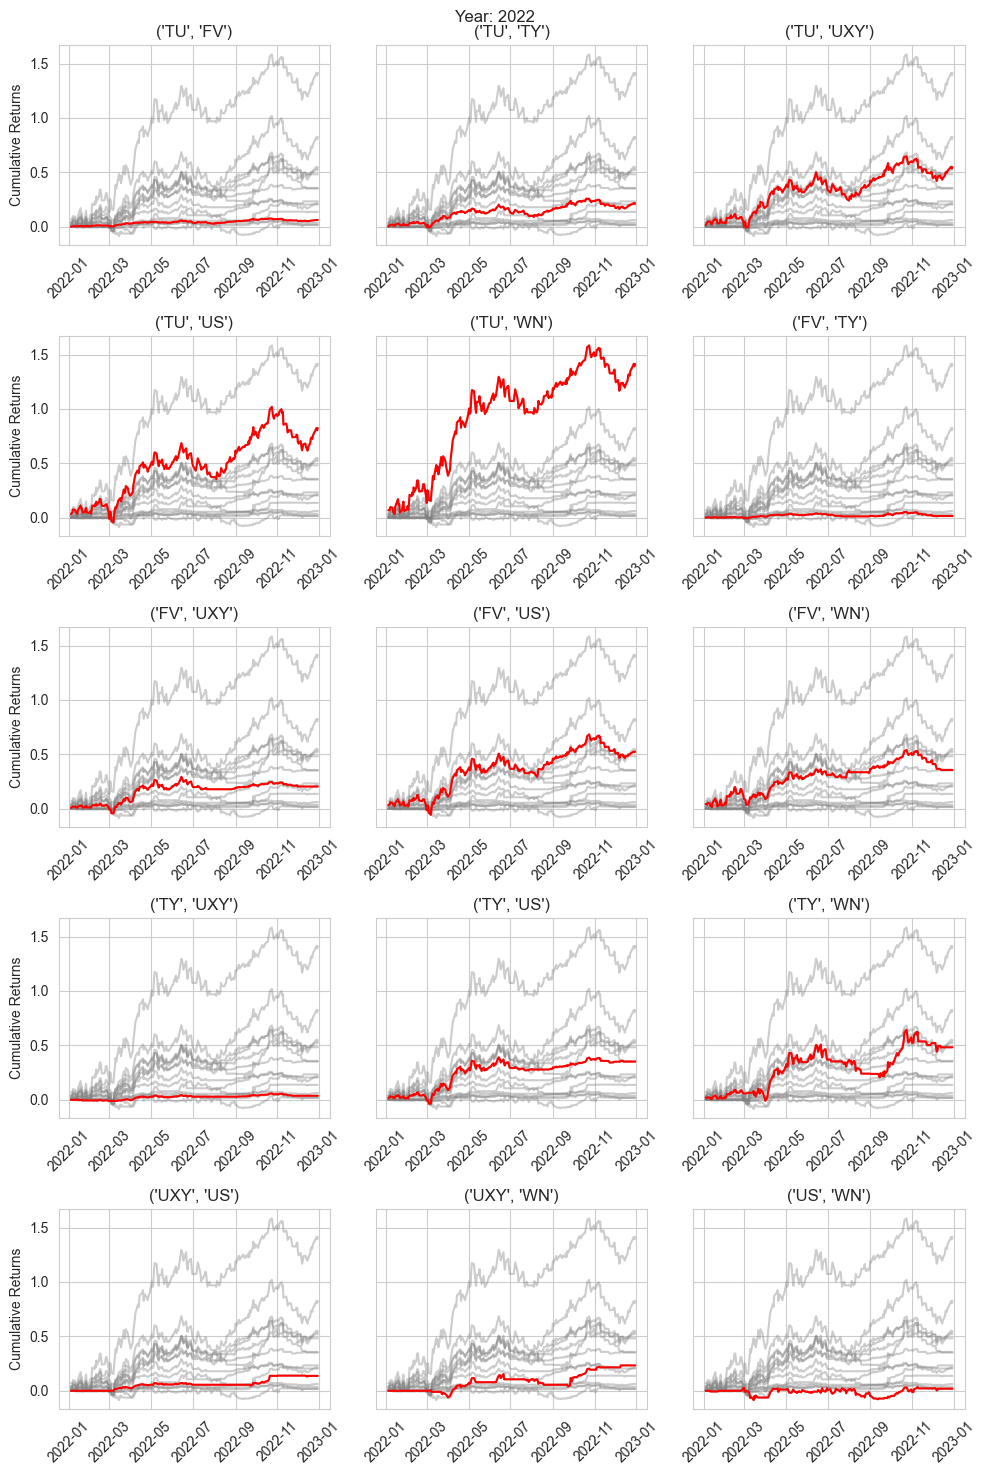

In [40]:
# Plot results

for year, agg_results in yearly_agg_results.items():
    cols = agg_results.columns

    # Make 5x3 subplots, and make them share an x-axis.
    fig, axs = plt.subplots(5, 3, sharey=True, figsize=(10, 15))

    for i in range(5):
        for j in range(3):
            axs[i, j].plot(agg_results, alpha=0.4, color='grey')
            axs[i, j].plot(agg_results[cols[i*3 + j]], color='red')
            axs[i, j].set_title(cols[i*3 + j])
            plt.setp(axs[i, j].get_xticklabels(), rotation=45)

            # Set y label
            if j == 0:
                axs[i, j].set_ylabel('Cumulative Returns')
            else:
                axs[i, j].set_ylabel('')

    # Adjust the spacing between subplots.
    plt.subplots_adjust(hspace=0.5)
    plt.subplots_adjust(wspace=0.5)
    fig.suptitle(f"Year: {year}")
    plt.tight_layout()
    plt.show()

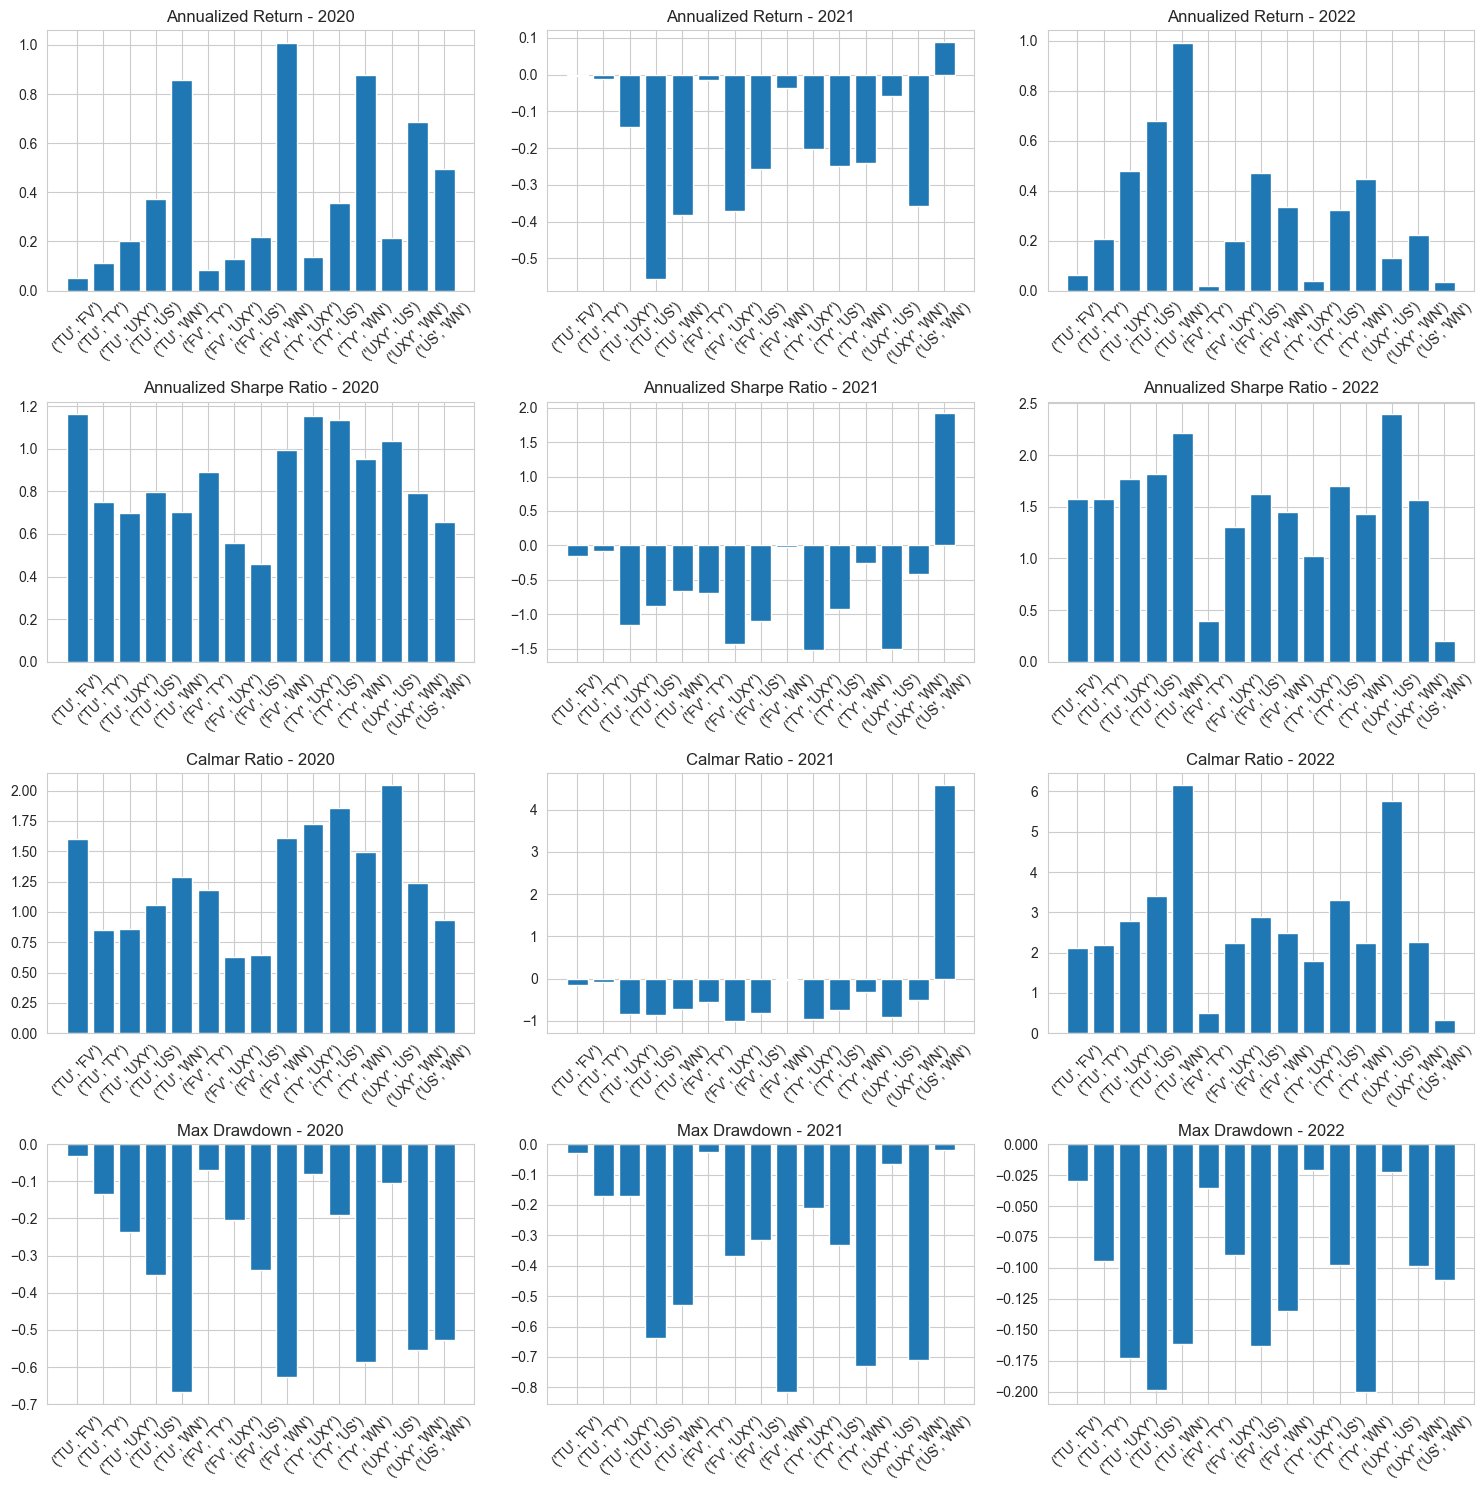

In [41]:
from analysis.performance import perf_summ

fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Plot the bar charts.
for idx, stat in enumerate(["Annualized Return", "Annualized Sharpe Ratio", "Calmar Ratio", "Max Drawdown"]):
    for j in range(3):
        # Get the year.
        year = str(2020 + j)
        summ = perf_summ(yearly_agg_returns[year], adj=252)
        labels = [str(i[0]) + ' ' + str(i[1]) for i in summ.index]
        axs[idx, j].bar(labels, summ[stat])
        axs[idx, j].set_title(f'{stat} - {year}')
        axs[idx, j].set_xticklabels(summ.index, rotation=45)

plt.tight_layout()
plt.show()

In [42]:
for year, agg_results in yearly_agg_returns.items():
    print(f"Year: {year}")
    display(perf_summ(agg_results, adj=252))

Year: 2020


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Calmar Ratio,Peak,Bottom,Recovery
"(TU, FV)",0.050614,0.043524,1.162910,1.044437,0.189498,11.268199,-0.002699,-0.006389,-0.014447,0.012645,-0.031586,1.602424,2020-03-09,2020-03-18,2020-03-23 00:00:00
"(TU, TY)",0.114342,0.152425,0.750149,0.638871,-0.057326,13.364156,-0.009475,-0.023410,-0.051957,0.048615,-0.134588,0.849571,2020-03-09,2020-03-18,2020-10-27 00:00:00
"(TU, UXY)",0.202596,0.290286,0.697918,0.695865,-0.095869,10.159739,-0.020153,-0.043531,-0.089986,0.081477,-0.236373,0.857103,2020-03-09,2020-03-18,2020-09-08 00:00:00
"(TU, US)",0.371568,0.466097,0.797190,0.899296,0.213838,12.419777,-0.033625,-0.065467,-0.153925,0.155578,-0.352159,1.055114,2020-03-09,2020-03-18,Not yet recovered
"(TU, WN)",0.856480,1.220444,0.701777,0.986404,0.843952,11.855588,-0.083887,-0.158312,-0.429147,0.434595,-0.666960,1.284155,2020-03-09,2020-03-18,Not yet recovered
"(FV, TY)",0.082195,0.092292,0.890596,0.805126,0.005000,14.331408,-0.006655,-0.013449,-0.033047,0.029719,-0.069691,1.179419,2020-03-09,2020-03-18,2020-03-30 00:00:00
"(FV, UXY)",0.128576,0.231253,0.555997,0.549218,-0.164130,11.732497,-0.017721,-0.034922,-0.076802,0.067050,-0.205365,0.626085,2020-03-09,2020-03-18,Not yet recovered
"(FV, US)",0.216961,0.474067,0.457658,0.548132,0.097751,8.858965,-0.037820,-0.068026,-0.148853,0.151647,-0.337433,0.642975,2020-03-09,2020-03-18,Not yet recovered
"(FV, WN)",1.008749,1.016610,0.992267,1.192257,0.973944,16.449136,-0.065748,-0.131716,-0.385044,0.397905,-0.625720,1.612141,2020-03-09,2020-03-18,2020-09-14 00:00:00
"(TY, UXY)",0.137364,0.119189,1.152488,1.100561,0.653823,16.038331,-0.008432,-0.015960,-0.043919,0.044913,-0.079814,1.721046,2020-03-16,2020-03-18,2020-04-01 00:00:00



Year: 2021


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Calmar Ratio,Peak,Bottom,Recovery
"(TU, FV)",-0.004542,0.030627,-0.148311,-0.176825,-0.333895,3.399339,-0.003228,-0.004801,-0.008301,0.006463,-0.027774,-0.163548,2021-01-05,2021-10-21,Not yet recovered
"(TU, TY)",-0.012625,0.153971,-0.081994,-0.109958,-0.527227,1.927368,-0.014524,-0.022967,-0.045241,0.026471,-0.172014,-0.073393,2021-01-05,2021-03-31,Not yet recovered
"(TU, UXY)",-0.143677,0.124616,-1.152959,-1.457851,-0.490179,2.225293,-0.014827,-0.019125,-0.037734,0.022638,-0.170262,-0.843861,2021-01-05,2021-08-03,Not yet recovered
"(TU, US)",-0.555328,0.636472,-0.872511,-1.294231,-0.026649,1.131690,-0.071148,-0.094329,-0.129376,0.133602,-0.637183,-0.871537,2021-01-05,2021-12-03,Not yet recovered
"(TU, WN)",-0.381991,0.574759,-0.664611,-0.935908,0.029195,2.646267,-0.061957,-0.084679,-0.161338,0.125020,-0.529412,-0.721538,2021-01-05,2021-07-19,Not yet recovered
"(FV, TY)",-0.013915,0.020054,-0.693868,-0.586126,-0.728020,5.457474,-0.002336,-0.003836,-0.005121,0.004754,-0.025605,-0.543447,2021-06-25,2021-12-03,Not yet recovered
"(FV, UXY)",-0.372097,0.259688,-1.432862,-2.091554,-0.225857,0.185954,-0.030450,-0.037120,-0.052388,0.041059,-0.367750,-1.011823,2021-01-05,2021-12-03,Not yet recovered
"(FV, US)",-0.257015,0.235759,-1.090160,-1.454149,-0.225473,1.097708,-0.026726,-0.036125,-0.049449,0.035834,-0.316875,-0.811091,2021-01-05,2021-12-03,Not yet recovered
"(FV, WN)",-0.036443,1.313721,-0.027740,-0.039078,0.696826,6.521206,-0.132491,-0.188357,-0.338571,0.482073,-0.815538,-0.044686,2021-01-05,2021-12-03,Not yet recovered
"(TY, UXY)",-0.201583,0.132724,-1.518812,-2.132653,-0.254023,0.399551,-0.015840,-0.019721,-0.027354,0.022540,-0.211414,-0.953500,2021-01-05,2021-12-03,Not yet recovered



Year: 2022


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Calmar Ratio,Peak,Bottom,Recovery
"(TU, FV)",0.062563,0.039846,1.570110,2.519297,-0.198318,0.664418,-0.003468,-0.005167,-0.008772,0.006698,-0.029709,2.105882,2022-06-14,2022-08-01,2022-09-20 00:00:00
"(TU, TY)",0.206535,0.131314,1.572842,2.680721,-0.110639,0.140688,-0.011710,-0.016459,-0.026205,0.020796,-0.094404,2.187777,2022-06-14,2022-08-04,2022-09-22 00:00:00
"(TU, UXY)",0.478595,0.269953,1.772880,3.202859,0.019120,0.016384,-0.023147,-0.032111,-0.044724,0.045995,-0.172509,2.774321,2022-06-14,2022-08-01,2022-09-22 00:00:00
"(TU, US)",0.678293,0.373517,1.815963,3.156334,0.091234,0.527656,-0.031558,-0.043999,-0.068398,0.079697,-0.199045,3.407745,2022-10-24,2022-12-15,Not yet recovered
"(TU, WN)",0.991918,0.448159,2.213317,3.724050,0.303581,0.948548,-0.036865,-0.053030,-0.083129,0.104060,-0.161198,6.153394,2022-10-24,2022-12-07,Not yet recovered
"(FV, TY)",0.017768,0.044499,0.399288,0.477094,-0.492309,4.095137,-0.004085,-0.007089,-0.013125,0.010520,-0.035571,0.499498,2022-10-24,2022-12-01,Not yet recovered
"(FV, UXY)",0.200219,0.153052,1.308178,2.026382,0.529033,1.898843,-0.014802,-0.018605,-0.031230,0.032082,-0.089784,2.230013,2022-06-14,2022-07-13,Not yet recovered
"(FV, US)",0.468995,0.288554,1.625329,2.664013,0.235653,1.187451,-0.024626,-0.035222,-0.056690,0.068261,-0.162903,2.878977,2022-02-16,2022-03-07,2022-03-21 00:00:00
"(FV, WN)",0.336104,0.231800,1.449973,2.048204,-0.109213,1.517425,-0.020108,-0.031689,-0.052666,0.046345,-0.134540,2.498166,2022-02-16,2022-03-04,2022-04-11 00:00:00
"(TY, UXY)",0.037465,0.036482,1.026947,1.566897,0.200754,1.287808,-0.003599,-0.004752,-0.007396,0.007711,-0.020803,1.800994,2022-10-24,2022-11-23,Not yet recovered


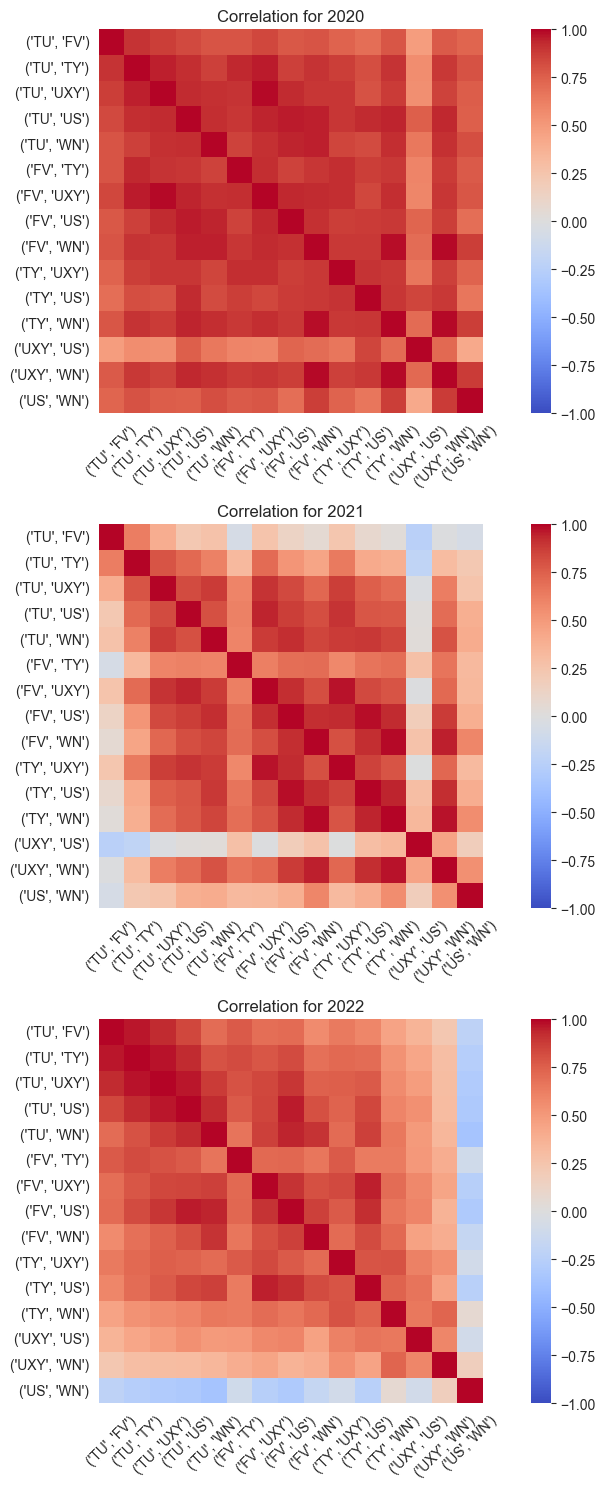

In [43]:
# Make a correlation heatmap for the returns.
import seaborn as sns

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i in range(3):
    year = str(2020 + i)
    corr = yearly_agg_returns[year].corr()

    # Set the title.
    axs[i].set_title(f"Correlation for {year}")

    # Plot the heatmap.
    sns.heatmap(corr, vmin=-1, vmax=1, ax=axs[i], cmap='coolwarm', square=True)

    # Rotate the xticklabels.
    plt.setp(axs[i].get_xticklabels(), rotation=45)

plt.tight_layout()